In [1]:
# import modules
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import os

import random
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

sns.set()

os.chdir('/Users/celiashi/Downloads')
#%pwd
#os.getcwd()

### Read In Data

#### Get file names in directory

In [2]:
files_csv=[]
for dirname, _, filenames in os.walk("project_data/"):
    for filename in filenames:
        files_csv.append(os.path.join(dirname, filename))
files_csv

['project_data/2020-Jan.csv',
 'project_data/2019-Dec.csv',
 'project_data/2020-Feb.csv',
 'project_data/2019-Nov.csv',
 'project_data/2019-Oct.csv']

#### Preview first file

In [3]:
pd.read_csv(files_csv[0], nrows=5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-01-01 00:00:00 UTC,view,5809910,1602943681873052386,NaN,grattol,5.24,595414620,4adb70bb-edbd-4981-b60f-a05bfd32683a
1,2020-01-01 00:00:09 UTC,view,5812943,1487580012121948301,NaN,kinetics,3.97,595414640,c8c5205d-be43-4f1d-aa56-4828b8151c8a
2,2020-01-01 00:00:19 UTC,view,5798924,1783999068867920626,NaN,zinger,3.97,595412617,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3
3,2020-01-01 00:00:24 UTC,view,5793052,1487580005754995573,NaN,NaN,4.92,420652863,546f6af3-a517-4752-a98b-80c4c5860711
4,2020-01-01 00:00:25 UTC,view,5899926,2115334439910245200,NaN,NaN,3.92,484071203,cff70ddf-529e-4b0c-a4fc-f43a749c0acb


#### Count rows per file

In [4]:
counts = {}
for file in files_csv:
    with open(file) as fp:
        for (count, _) in enumerate(fp, 1):
            pass
    counts[file] = count

for file,cnt in counts.items():
    print(f"File {file} has {cnt} rows".replace("project_data/",""))

cnt = 0
for v in counts.values():
    cnt+=v
print(f"In total there are {cnt} rows!")

File 2020-Jan.csv has 4264753 rows
File 2019-Dec.csv has 3533287 rows
File 2020-Feb.csv has 4156683 rows
File 2019-Nov.csv has 4635838 rows
File 2019-Oct.csv has 4102284 rows
In total there are 20692845 rows!


#### Combine files into a single dataset

In [5]:
# this is a big dataset! one way to work with it would be to just use a random sample
def import_df_func(perc_sample=1): 
    frame=[]
    for i in range(len(files_csv)):
        df_i=pd.read_csv(files_csv[i]).sample(frac=perc_sample, replace=False)
        df_i['month']=files_csv[i][-7:-4]
        frame.append(df_i)
    return pd.concat(frame,ignore_index=True,sort=False)

df = import_df_func(.1)
    
print(f"The dataframe has {df.shape[0]} rows and {df.shape[1]} columns")

The dataframe has 2069284 rows and 10 columns


### Exploratory Data Analysis & Data Preprocessing

#### Explore data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2069284 entries, 0 to 2069283
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
 9   month          object 
dtypes: float64(1), int64(3), object(6)
memory usage: 157.9+ MB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
product_id,2069284.0,5.482938e+06,1.308389e+06,3.752000e+03,5.724641e+06,5.810674e+06,5.857771e+06,5.932595e+06
category_id,2069284.0,1.554250e+18,1.690368e+17,1.487580e+18,1.487580e+18,1.487580e+18,1.487580e+18,2.242903e+18
price,2069284.0,8.520648e+00,1.930821e+01,-7.937000e+01,2.060000e+00,4.050000e+00,6.980000e+00,3.277800e+02
user_id,2069284.0,5.215626e+08,8.746173e+07,2.963072e+06,4.819714e+08,5.531530e+08,5.788544e+08,6.220885e+08


#### What are the most popular brands?

In [8]:
sales_by_brand = df[df.event_type=='purchase'].groupby('brand')['price'].sum().reset_index().sort_values('price', ascending=False)

<AxesSubplot:>

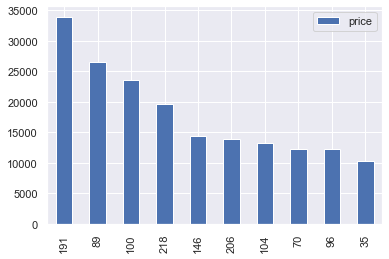

In [9]:
sales_by_brand[:10].plot(kind='bar')

#### Of all people who add an item to their cart, how many actually complete a purchase?

In [10]:
str(round(len(df[df.event_type=='purchase']) / len(df[df.event_type=='cart']) * 100, 1)) + '%'

'22.2%'

#### Clean file

In [11]:
    # step 1: select customers who purchased (assuming only analyzing sales, don't do this for funnel analysis)
df=df.loc[df.event_type=='purchase',:]

    # step 2: drop "category_code", "brand", "product_id", "category_id", and "user_session"
df=df.drop(columns=['category_code','brand','product_id','category_id','user_session'])

    # step 3: drop duplicates
df=df.drop_duplicates()

    # step 4: convert "event_time" to DateTime format
df['event_time']=pd.to_datetime(df['event_time'],infer_datetime_format=True)

nullcols=df.isnull().sum()
nullnum=len(nullcols[nullcols!=0])
print(f"After data selection and cleansing, the dataframe has {df.shape[0]} rows, {df.shape[1]} columns, and {nullnum} null value.\n")
print("Shown below are the first 3 rows of the cleaned dataframe:\n")
df.head(3)

After data selection and cleansing, the dataframe has 118859 rows, 5 columns, and 0 null value.

Shown below are the first 3 rows of the cleaned dataframe:



,event_time,event_type,price,user_id,month
26,2020-01-10 09:19:54+00:00,purchase,3.65,562208352,Jan
39,2020-01-26 13:51:07+00:00,purchase,2.05,588414232,Jan
40,2020-01-24 17:21:22+00:00,purchase,15.08,597457382,Jan


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I was curious about the number of customers and sales over time. After more data manipulation (see codes below for details), the time series analysis showed that

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(1) the number of customers spiked in Nov 2019 (Thanksgiving?) and the end of Jan 2020 (sales event?). There was a big drop in customer numbers on New Year’s Eve (system downtime?); 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(2) sales went up from ~0.95 million dollars in Oct 2019 to ~1.3 million dollars in Nov 2019, fell to ~0.85 million dollars in Dec 2019, and then remained ~1 million dollars/month in the following 2 months;

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(3) the average spend per customer didn’t change much over the 5 months.

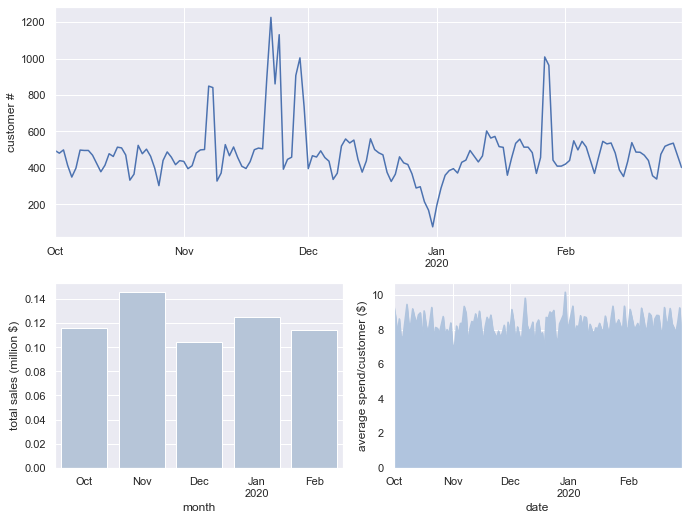

In [12]:
# initial data exploration

plt.figure(figsize=(10,8))

# plot the number of customers each day 
plt.axes([0.08, 0.4, 0.87, 0.4])
df_sales_n_user=df.resample("D",on='event_time')['user_id'].nunique()
df_sales_n_user.plot(kind='line')
plt.xlabel('')
plt.ylabel('customer #')

# plot total sales/month 
plt.axes([0.08,0,0.4,0.32])
a=df.resample('M',on='event_time')['price'].sum().to_frame()
a['month']=['Oct','Nov','Dec',"Jan\n2020", "Feb"]
a['price']=a['price']/1000000
sns.barplot(x='month',y='price',data=a,color="lightsteelblue")
plt.xlabel('month')
plt.ylabel('total sales (million $)')

# plot average spend/customer
plt.axes([0.55,0,0.4,0.32])
df_sales_p_day=df.resample('D',on='event_time')['price'].sum()
df_sales_spent=df_sales_p_day/df_sales_n_user
df_sales_spent.plot(kind='area',color="lightsteelblue")
plt.xlabel('date')
plt.ylabel('average spend/customer ($)');

### Basic Prophet Example

In [14]:
# The major dependency that Prophet has is pystan. PyStan has its own installation instructions. 
# Install pystan with pip before using pip to install fbprophet.
%pip install pystan
%pip install fbprophet
from fbprophet import Prophet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [15]:
df['event_day'] = df['event_time'].dt.date  # truncate datetime to just date
df_sales = df.groupby(['event_day'])['price'].sum().reset_index() #sum purchases by day
df_sales['price'] *= 10 #multiply by 10 b/c we used a sample of the data
df_sales.columns = ['ds','y'] #column names that Prophet expects
df_sales

,ds,y
0,2019-10-01,46985.0
1,2019-10-02,42241.4
2,2019-10-03,38896.8
3,2019-10-04,35695.5
4,2019-10-05,25964.7
...,...,...
147,2020-02-25,42041.1
148,2020-02-26,41365.8
149,2020-02-27,45262.9
150,2020-02-28,43446.3


In [17]:
m = Prophet(daily_seasonality=True)
m.fit(df_sales)
m

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [18]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
177,2020-03-26
178,2020-03-27
179,2020-03-28
180,2020-03-29
181,2020-03-30


In [19]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
177,2020-03-26,43633.008222,27587.602517,60003.567865
178,2020-03-27,41289.557208,25638.581886,56491.472631
179,2020-03-28,31426.192447,16822.108016,48101.932339
180,2020-03-29,35437.019003,19753.321119,51609.694776
181,2020-03-30,42724.313907,27679.961772,59276.267743


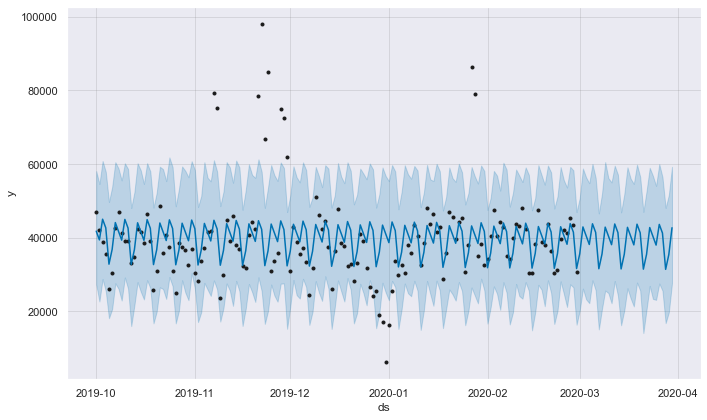

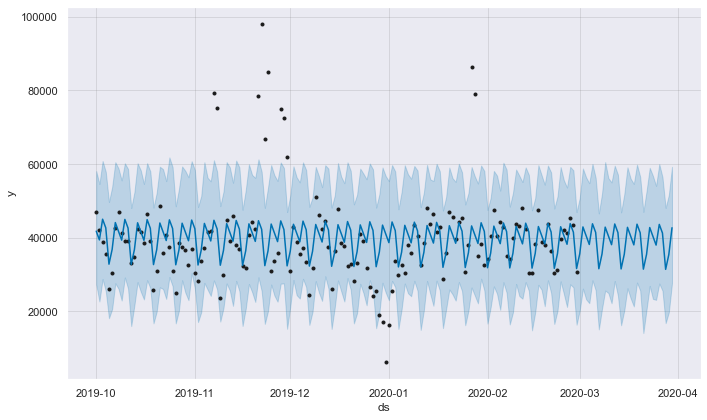

In [20]:
m.plot(forecast)

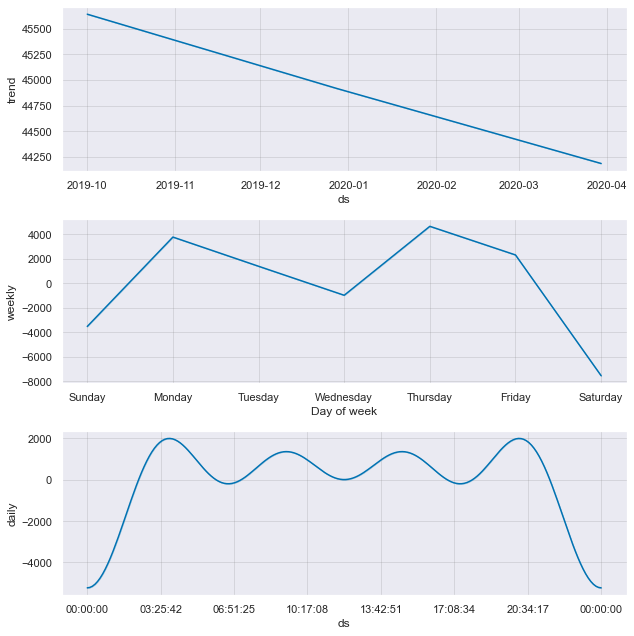

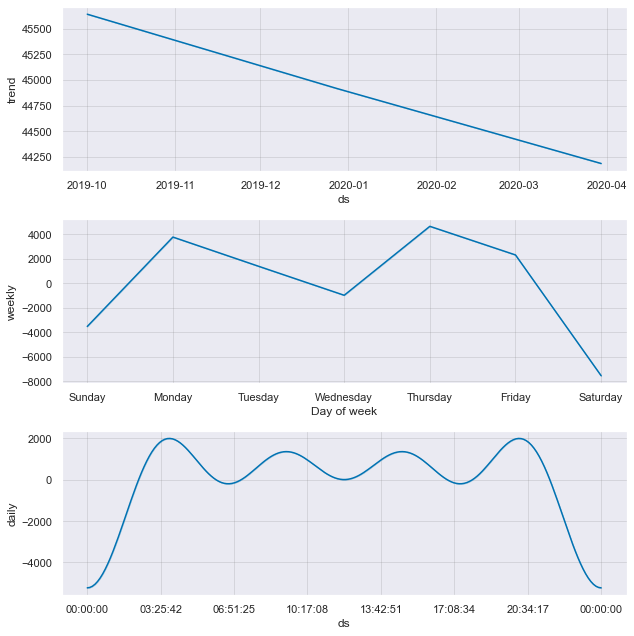

In [21]:
m.plot_components(forecast)

### Clustering Example

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Though the distribution of the number of customers indicated that other unrecorded factors had influenced our customer behavior, I decided to ignore them for now and continue my analysis before I obtain more details from our marketing team. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Next, I grouped the data by user_id, and calculated each customer’s Recency (how many months until Feb 29, 2020 had it been since the customer’s last purchase), Frequency (how often had the customer made a purchase from Oct 2019 to Feb 2020), and Monetary Value (how much did the customer spend from Oct 2019 to Feb 2020). 

In [22]:
# Here we'll group the data by user_id, and calculate each customer's recency, frequency, and monetary value
# See this article for an example https://www.kaggle.com/jianlizhou/customer-segmentation-by-rfm-model-and-k-means

In [23]:
# step 1: calculate "Recency", set Feb 2020 as the reference month, and use "month" as the unit
d={"Oct":4,"Nov":3,"Dec":2,"Jan":1,"Feb":0}
df['Recency'] = df['month'].map(d)
df_R=df.groupby('user_id')['Recency'].min().reset_index().rename(columns={"0":"Recency"})
df_R.head()

,user_id,Recency
0,10280338,0
1,12055855,2
2,19762782,3
3,23633626,1
4,25300038,0


In [24]:
# step 2: calculate "Frequency"
df_F=df.groupby('user_id')['event_type'].count().reset_index().rename(columns={"event_type":"Frequency"})
df_F.head()

,user_id,Frequency
0,10280338,6
1,12055855,1
2,19762782,1
3,23633626,2
4,25300038,1


In [25]:
# step 3: calculate "Monetary"
df_M=df.groupby('user_id')['price'].sum().reset_index().rename(columns={"price":"Monetary"})
df_M.head()

,user_id,Monetary
0,10280338,15.72
1,12055855,5.48
2,19762782,10.00
3,23633626,2.89
4,25300038,2.78


In [26]:
# step 4: merge "Recency", "Frequency", and "Monetary"
df_RF=pd.merge(df_R,df_F,on='user_id')
df_RFM=pd.merge(df_RF,df_M,on='user_id')
df_RFM.head()

,user_id,Recency,Frequency,Monetary
0,10280338,0,6,15.72
1,12055855,2,1,5.48
2,19762782,3,1,10.00
3,23633626,1,2,2.89
4,25300038,0,1,2.78


In [27]:
# step 5: remove outliers before K-Means clustering
conditions=np.abs(stats.zscore(df_RFM.loc[:,['Recency','Frequency','Monetary']]) < 3).all(axis=1)
df_RFM2=df_RFM.loc[conditions,:]

df_RFM2.head(3)

,user_id,Recency,Frequency,Monetary
0,10280338,0,6,15.72
1,12055855,2,1,5.48
2,19762782,3,1,10.00


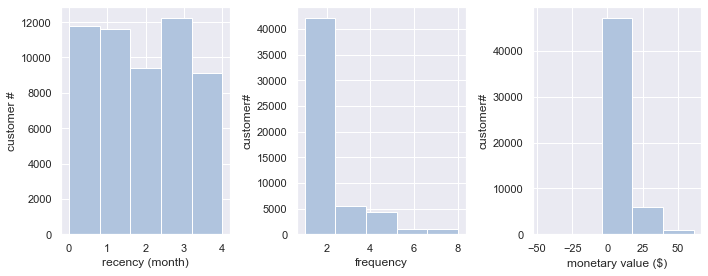

In [28]:
# visualize the distribution of "Recency", "Frequency", and "Monetary"
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,4))

# plot "Recency"
ax1.hist(df_RFM2['Recency'],bins=5,color='lightsteelblue')
ax1.set_xticks(np.arange(0,5,1))
ax1.set_xlabel('recency (month)')
ax1.set_ylabel('customer #')

# plot "Frequency"
ax2.hist(df_RFM2['Frequency'],bins=5,color='lightsteelblue')
ax2.set_xlabel('frequency')
ax2.set_ylabel('customer#')

# plot "Monetary"
ax3.hist(df_RFM2['Monetary'],bins=5,color='lightsteelblue')
ax3.set_xlabel('monetary value ($)')
ax3.set_ylabel('customer#')

plt.tight_layout()

### Part II: Customer Segmentation by RFM-Based K-Means Clustering

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Traditionally, in RFM models, each customer is assigned a score for each RFM factor. These scores are then combined and used for segmentation. Inspired by Chen (2012), I decided to do RFM analysis by K-Means clustering. The first two things I did were to standardize the data and then find the optimal number of clusters by the elbow method.

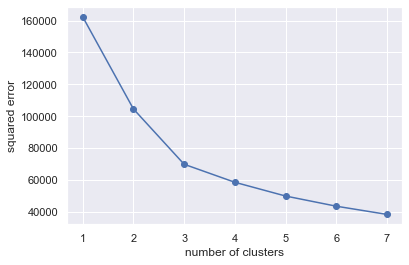

In [29]:
# k-means clustering: using recency, frequency, and monetary as clustering varaibles

# step 1: standardize data
df_RFM3=df_RFM2.drop(columns=['user_id'])
X = StandardScaler().fit_transform(df_RFM3)

# step 2: find the optimal number of clusters
SSE=[]
for i in range(1,8,1):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(X)
    SSE.append(kmeans.inertia_)
sns.set()
plt.plot(range(1,8,1),SSE,marker='o')
plt.xlabel('number of clusters')
plt.ylabel('squared error');

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Based on the graph above, I decided to group our customers into 4 clusters by K-Means. The 3D scatter plot showed that the 4 groups were well separated.

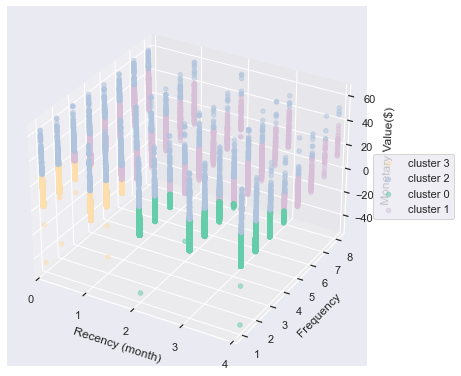

In [30]:
# k-means clustering: using recency, frequency, and monetary as clustering varaibles

# step 3: group customers into 4 clusters
random.seed(8)
km=KMeans(n_clusters=4,random_state=0)
km.fit(X)
random.seed(8)
pred=km.predict(X)
df_RFM2=df_RFM2.assign(clusters=pred)

# step 4: visualize the 4 clusters

# step 4_1: data preparation
R=[]
F=[]
M=[]
mycolors=['navajowhite','lightsteelblue','mediumaquamarine','thistle']
cluster_orders=[3,2,0,1]
for i in [0,1,2,3]:
    R.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Recency'].values.tolist())
    F.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Frequency'].values.tolist())
    M.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Monetary'].values.tolist())
    
# step 4_2: 3D scatter plot
fig=plt.figure(figsize=(8,5))
ax=Axes3D(fig)
for i in [0,1,2,3]:
    ax.scatter(R[i], F[i], M[i], c=mycolors[i], marker='o',alpha=0.5,label='cluster '+str(cluster_orders[i]))
ax.set_xlabel('Recency (month)')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value($)')
ax.set_xlim(0,4)
ax.set_xticks(list(range(5)))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I must admit that I’ve never liked 3D graphs. I don’t want to call my customer segments neither “cluster 1” nor “cluster 2”. So, I replaced the old cluster names with more meaning segment names and re-plotted the data.

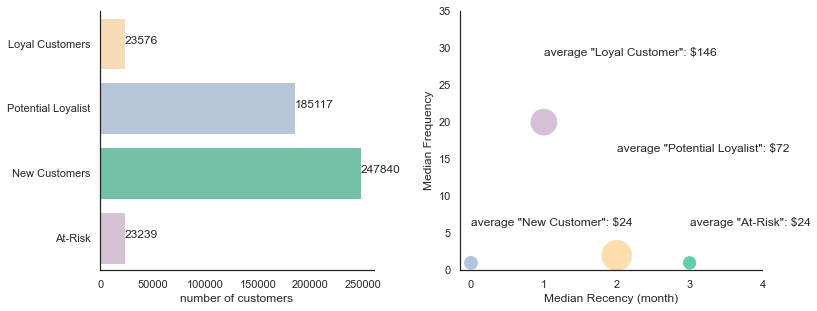

In [18]:
# replace k-means cluster names with more meaningful names
d1={0:"New Customers", 2:"Potential Loyalist", 1: "At-Risk", 3:"Loyal Customers"}
df_RFM2.loc[:,"segments"]=df_RFM2.loc[:,"clusters"].map(d1)

# calculate the number of customers, median recency, median frequency, 
# and average customer spend in each customer segment
df_RFM3=df_RFM2.groupby('segments').agg(Recency=('Recency',np.median),Frequency=('Frequency',np.median),MonetarySum=('Monetary',np.sum),size=("clusters",'size'))
df_RFM3.loc[:,'Sales/Customer']=round(df_RFM3.loc[:,'MonetarySum']/df_RFM3.loc[:,'size'])
df_RFM3=df_RFM3.astype({'Sales/Customer':int}).reset_index()

# visualize
plt.figure(figsize=(10,4))
seg_names=['Loyal Customers','Potential Loyalist','New Customers','At-Risk']

# plot the number of customers in each segment
sns.set_style("white")
plt.axes([0, 0, 0.38, 0.9])
seg=df_RFM2.groupby('segments').size().to_frame().rename(columns={0:'number of customers'}).reset_index()
sns.barplot(x='number of customers',y='segments',data=seg,order=seg_names,palette=mycolors)
for i in [0,1,2,3]:
    number=int(seg.loc[seg.segments==seg_names[i],'number of customers'])
    x_pos=round(number,-2)
    plt.text(x_pos,i,number)
plt.ylabel("")
sns.despine()

# plot recency, frequency, and average spend/customer of the 4 segments
plt.axes([0.5,0,0.42,0.9])
sns.scatterplot(x='Recency',y='Frequency',hue='segments',hue_order=seg_names,palette=mycolors,size='Sales/Customer',sizes=(200,1000),legend=False,data=df_RFM3)
plt.ylim(0,35)
plt.xticks(list(range(5)))
plt.text(1,29,'average "Loyal Customer": $146')
plt.text(2,16,'average "Potential Loyalist": $72')
plt.text(0,6,'average "New Customer": $24')
plt.text(3,6,'average "At-Risk": $24')
plt.xlabel('Median Recency (month)')
plt.ylabel('Median Frequency')
sns.despine()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Taken together, our customers were grouped into 4 segments:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(1)	Loyal Customers: These customers purchased very often and spent the highest amount of money. They shopped from Oct 2019 to Feb 2020 with a median recency of 1 month. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(2)	Potential Loyalist: This group shopped quite often (though not as frequent as the loyal customers) and spent reasonable amount of money (though not as high as the loyal customers). 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(3)	New Customers: I was so surprised that we had such a large group of new customers. They started shopping very recently and as a result, they didn’t make purchases often nor spend much money.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(4)	At-Risk: This is the largest-sized group!!! These customers have high recency, low frequency, and low monetary.

### Part III: Examine the Relationship between the Probability of Purchasing and RFM

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;As a very curious data analyst, I always like to dig a little deeper. I wanted to find out how a customer’s recency, frequency, and monetary value would affect his or her repurchase probability. To address my own question, I did the following things:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(1) I calculated the Recency, Frequency, and Monetary Value of each customer using data from Oct 2019 to Jan 2020. Jan 2020 was used as the reference month; 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(2)
I assigned the customers who made >=1 purchase in Feb 2020 to the “buy” (1) group, and those who didn’t buy in Feb 2020 to the “no-buy” (0) group; 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(3) I grouped the data by recency, frequency, and monetary, respectively, and calculated the percentage of the “buy” group in each recency/frequency/monetary bin; 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(4) I plotted the percentage (purchase probability in Feb 2020) against recency/frequency/monetary.

In [20]:
# explore the relationship between customers' purchase probability in Feb 2020 and their Recency,Frequency,
# and Monetary in previous months
df_sales = df.copy()

# step 1: calculate recency, Frequency, and Monetary in Oct 2019-Jan 2020
df_sales1=df_sales.loc[df_sales.month!='Feb',:].copy()
d={"Oct":3,"Nov":2,"Dec":1,"Jan":0}
df_sales1.loc[:,'Recency']=df_sales1.loc[:,'month'].map(d)
df_sales1_R=df_sales1.groupby('user_id')['Recency'].min().reset_index()
df_sales1_F=df_sales1.groupby('user_id')['event_type'].count().reset_index().rename(columns={'event_type':'Frequency'})
df_sales1_RF=pd.merge(df_sales1_R,df_sales1_F,on='user_id')
df_sales1_M=df_sales1.groupby('user_id')['price'].sum().reset_index().rename(columns={'price':"Monetary"})
df_sales2=pd.merge(df_sales1_RF,df_sales1_M,on='user_id')
                   
# step 2_1: find out customers who made purchases in Feb 2020
df_sales_feb_buyers=df_sales.loc[df_sales.month=='Feb','user_id'].unique().tolist()

# step 2_2: combine step 1 and step 2 results and remove outliers
df_sales2.loc[:,'Buy']=np.where(df_sales2['user_id'].isin(df_sales_feb_buyers),1,0)
conditions=np.abs(stats.zscore(df_sales2[['Recency','Frequency','Monetary']]) < 3).all(axis=1)
df_sales2=df_sales2.loc[conditions,:]
print("Shown below are the first 3 rows of the cleaned dataframe:\n")
display(df_sales2.head(3))

Shown below are the first 3 rows of the cleaned dataframe:



,user_id,Recency,Frequency,Monetary,Buy
0,1458813,2,4,20.62,0
1,4103071,3,1,2.38,0
2,4891613,1,1,9.32,0


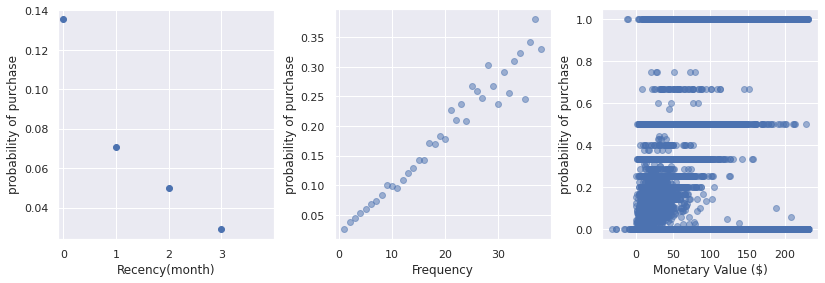

In [11]:
# Step 3 and 4: calculate and visualize the relationship between the probability of purchasing and RFM 
sns.set()
plt.figure(figsize=(12,4))

# plot purchase probability and Recency 
plt.axes([0,0,0.25,0.8])
df_Buy_R=df_sales2.groupby('Recency').agg(Number=('Buy','count'),Buy=('Buy','sum'))
df_Buy_R['Probability']=df_Buy_R['Buy']/df_Buy_R['Number']
plt.scatter(x=df_Buy_R.index,y=df_Buy_R.Probability)
plt.xlim(-0.1,4)
plt.xticks(np.arange(0,4,1))
plt.xlabel('Recency(month)')
plt.ylabel('probability of purchase')

# plot purchase probability and Frequency
plt.axes([0.32,0,0.25,0.8])
df_Buy_F=df_sales2.groupby('Frequency').agg(Number=('Buy','count'),Buy=('Buy','sum'))
df_Buy_F['Probability']=df_Buy_F['Buy']/df_Buy_F['Number']
plt.scatter(x=df_Buy_F.index,y=df_Buy_F.Probability,alpha=0.5)
plt.xlabel('Frequency')
plt.ylabel('probability of purchase')

# plot purchase probability and Monetary
plt.axes([0.63,0,0.25,0.8])
df_Buy_M=df_sales2.groupby('Monetary').agg(Number=('Buy','count'),Buy=('Buy','sum'))
df_Buy_M['Probability']=df_Buy_M['Buy']/df_Buy_M['Number']
plt.scatter(x=df_Buy_M.index,y=df_Buy_M.Probability,alpha=0.5)
plt.xlabel('Monetary Value ($)')
plt.ylabel("probability of purchase");

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The probability of repurchasing in Feb 2020 increased as the customers’ recency decreased. For example, customers who were active in Jan 2020 (Recency=0) had about 4 times as high probability of repurchasing as those who made their last order in Oct 2019 (Recency=3). There was somewhat of a linear relationship between the probability of purchase and frequency. Customers with higher number of transactions were more likely to repurchase. However, how much a customer spent over the past 4 months didn’t seem to have any obvious relationships with his or her purchase probability.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In summary, using the RFM-based K-Means clustering method, I grouped customers into 4 segments: (1) Loyal Customers; (2) Potential Loyalist; (3) New Customers; (4) At-Risk. Additionally, I found that there is a negative association between recency and purchase probability, and a positive relationship between frequency and purchase probability. I hope my work could help our marketing team design effective campaigns.





__References__

Chen Daqing (2012). Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining. Database Marketing & Customer Strategy Management 19, 197-208
